# `bbhx` Tutorial

`bbhx` is a software package that produces black hole binary waveforms. It focuses on LISA and provides the proper LISA response function for MBHBs ([arXiv:1806.10734](https://arxiv.org/abs/1806.10734), [arXiv:2003.00357](https://arxiv.org/abs/2003.00357)). `bbhx` also provides fast likelihood functions. The package is GPU-accelerated for fast analysis. 

If you use this software please cite [arXiv:2005.01827](https://arxiv.org/abs/2005.01827) and [arXiv:2111.01064](https://arxiv.org/abs/2111.01064) any parts within the package that you use (like waveforms and response functions). See the `citation` attribute for each class. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from bbhx.waveformbuild import BBHWaveformFD
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.response.fastfdresponse import LISATDIResponse
from bbhx.utils.constants import *

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


## GPU accelerated MBHB waveforms for LISA

First, we will detail how to produce full waveforms for MBHBs to be detected by LISA. We will look at how to generate PhenomHM waveforms ([arXiv:1708.00404](https://arxiv.org/abs/1708.00404), [arXiv:1508.07253](https://arxiv.org/abs/1508.07253), [arXiv:1508.07250](https://arxiv.org/abs/1508.07250)) put through the LISA response function (([arXiv:1806.10734](https://arxiv.org/abs/1806.10734), [arXiv:2003.00357](https://arxiv.org/abs/2003.00357)). More information on generating the waveforms and response separately can be found below. 

In [2]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))

In [3]:
# set parameters
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 1e6 
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 3e3  * PC_SI * 1e6 # 3e3 in Mpc 
inc = np.pi/3.
beta = np.pi/4.  # ecliptic latitude
lam = np.pi/5.  # ecliptic longitude
psi = np.pi/6.  # polarization angle 
t_ref = 1.0 * YRSID_SI  # t_ref  (in the SSB reference frame)

# frequencies to interpolate to
freq_new = np.logspace(-4, 0, 10000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]


Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

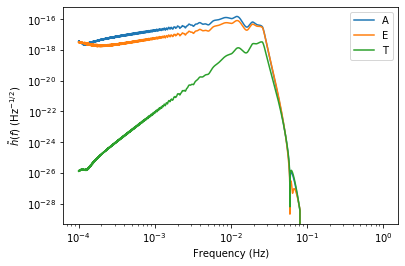

In [4]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Adjust inspiral timing with `shift_t_limits=False`

You can move the end of the signal further back in time from merger by changing `t_obs_end`. You can also adjust how far back in time the waveform starts with `t_obs_start`. With `shift_t_limits=False`, these values are relative to `t_ref`. So `t_obs_start = 1.0` means 1 year before coalescence. 

Chopping the signal can make the signal look like it abrubtly loses power. This is the case because different harmonic modes turn off abruptly at different frequencies. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

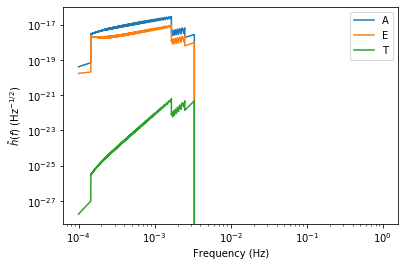

In [5]:
# start at one month
t_obs_start = 1./12.

# end 1 hour before merger
t_obs_end = 3600. / YRSID_SI

wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024,
                t_obs_start=t_obs_start, t_obs_end=t_obs_end)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Adjust inspiral timing with `shift_t_limits=True`

With `shift_t_limits=True`, these values are relative to `t_ref`. So `t_obs_start = 1.0` means 1 year before coalescence. 

Based on the `t_ref` of the system we are examining, with `t_obs_start=0`, `t_obs_end=0.75` years, `shift_t_limits=True`, only an early low-power portion of the signal is observed.  

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

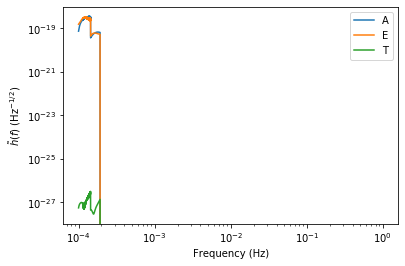

In [6]:
# start at the beginning of observation
t_obs_start = 0.0

# end after 0.75 years
t_obs_end = 0.75

wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024,
                shift_t_limits=True, t_obs_start=t_obs_start, t_obs_end=t_obs_end)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Controlling interpolation

The user has the option to control the interpolation by providing the number of frequencies to interpolate over with the `length` keyword argument. 

Text(0.5, 0, 'Frequency (Hz)')

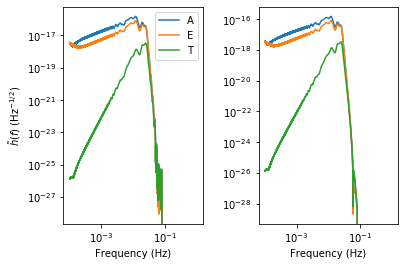

In [7]:
# number of points is too small
length = 128

wave1 = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=length,
                )[0] 

# high number of points is good
length = 16384

wave2 = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=length,
                )[0] 

fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)
for i, let in enumerate(["A", "E", "T"]):
    ax[0].loglog(freq_new, np.abs(wave1[i]), label=let)
    ax[1].loglog(freq_new, np.abs(wave2[i]), label=let)
ax[0].legend()
ax[0].set_ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")
ax[0].set_xlabel("Frequency (Hz)")
ax[1].set_xlabel("Frequency (Hz)")

#### Check number of points that is good for interpolation:

Generally, most reasonable numbers of points are fine for interpolation. We usually put 1024 to be conservative. It can slightly affect the waveform timing.

Text(0, 0.5, 'Mismatch')

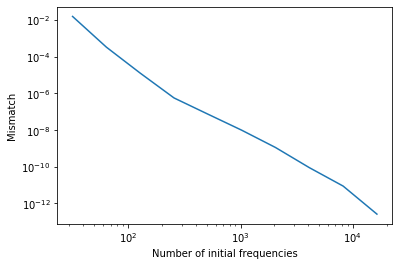

In [8]:
# compute directly first (see below)
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=True, squeeze=True,
                ) 

lengths_in = 2**np.arange(5, 15)[::-1]
mismatch = np.zeros_like(lengths_in, dtype=float)
for j, length in enumerate(lengths_in):
   # compute directly first (see below)
    wave_temp = wave_gen(m1, m2, a1, a2,
                              dist, phi_ref, f_ref, inc, lam, 
                              beta, psi, t_ref, freqs=freq_new,
                              direct=False, fill=True, squeeze=True, length=length
                    )[0]
    
    num = np.sum([np.dot(wave_temp[i].conj(), wave[i]) for i in range(3)])
    den1 = np.sum([np.dot(wave[i].conj(), wave[i]) for i in range(3)])
    den2 = np.sum([np.dot(wave_temp[i].conj(), wave_temp[i]) for i in range(3)])
    overlap = num / np.sqrt(den1 * den2)
    mismatch[j] = 1 - overlap.real

plt.loglog(lengths_in, mismatch) 
plt.xlabel("Number of initial frequencies")
plt.ylabel("Mismatch")

### Generate waveforms without interpolation

When interpolating, frequencies between $10^{-4}/M$ and $0.6/M$ are evaluated. Therefore, when not interpolating, the evaluation of the waveform will stretch outside these limits if frequencies outside those limits are given by the user. 

With `compress=True`, all modes will be directly combined. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

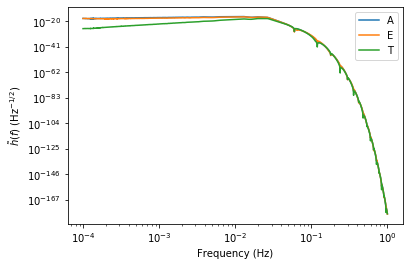

In [9]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=True, squeeze=True,
                ) 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")


With `compress=False`, it will keep the modes separate.

(1e-27, 1e-14)

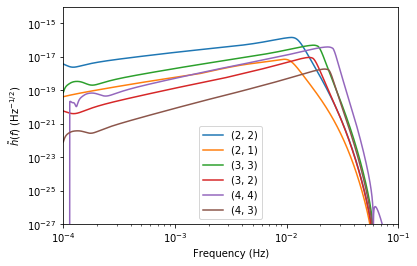

In [10]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=False, squeeze=True,
                ) 

for i, mode in enumerate(wave_gen.amp_phase_gen.modes):
    plt.loglog(freq_new, np.abs(wave[0][i]), label=mode)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

plt.xlim(1e-4, 1e-1)
plt.ylim(1e-27, 1e-14)

### Adjusting mode content

You can adjust the mode content with the `modes` keyword argument. You will receive an error if the requested mode indices $(l,m)$ are not available for the given waveform model chosen. 

(1e-27, 1e-14)

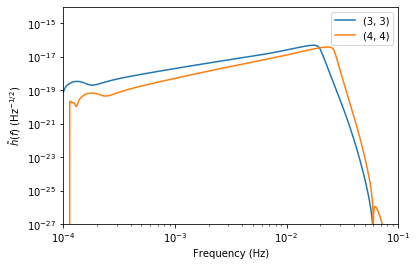

In [11]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=[(3,3),(4,4)], direct=True, compress=False, squeeze=True,
                ) 

for i, mode in enumerate(wave_gen.amp_phase_gen.modes):
    plt.loglog(freq_new, np.abs(wave[0][i]), label=mode)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

plt.xlim(1e-4, 1e-1)
plt.ylim(1e-27, 1e-14)

### All of these functions can take arrays for parameters

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

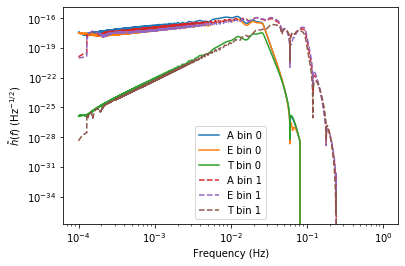

In [12]:
# set parameters
f_ref = np.array([0.0, 0.0])  # let phenom codes set fRef -> fmax = max(f^2A(f))
phi_ref = np.array([0.0, 1.0])
m1 = np.array([1e6, 4e5])
m2 = np.array([5e5, 1e5])
a1 = np.array([0.2, 0.8])
a2 = np.array([0.4, 0.7])
dist = np.array([3e3, 2.1e3])  * PC_SI * 1e6 # 3e3 in Mpc 
inc = np.array([np.pi/3, np.pi/4])
beta = np.array([np.pi/4., np.pi/5])
lam = np.array([np.pi/5., np.pi/6])
psi = np.array([np.pi/6., np.pi/7])
t_ref = np.array([1.0, 1.2]) * YRSID_SI  # in the SSB reference frame

# frequencies to interpolate to
freq_new = np.logspace(-4, 0, 10000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]

waves = wave_gen(m1, m2, a1, a2,
                  dist, phi_ref, f_ref, inc, lam, 
                  beta, psi, t_ref, freqs=freq_new,
                  modes=modes, direct=False, fill=True, squeeze=False, length=1024)

for j, ls in enumerate(["solid", "dashed"]):
    for i, let in enumerate(["A", "E", "T"]):
        plt.loglog(freq_new, np.abs(waves[j][i]), label=let + f" bin {j}", ls=ls)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### The `fill` keyword argument

The `fill` keyword argument allows the user to fill the data stream as in the first example above. However, it can give two other returns. (It is only available when `direct=False`.

If `fill=False`, it will return special information used in the fast likelihood function. This includes templates as shortened arrays (only the values where $\tilde{h}(f)$ is non-zero), the information on which frequency each array starts at and its length.

[array([[ 3.38058890e-18-1.09436679e-18j, -1.36063812e-18-3.36650411e-18j,
        -3.27697582e-18+1.60878942e-18j, ...,
        -3.43530029e-29-1.80550806e-29j,  1.19848650e-29-3.57844517e-29j,
         2.23006336e-29-2.91388205e-29j],
       [-9.88092867e-19-2.88388847e-18j, -2.74455381e-18+1.31741168e-18j,
         1.62653861e-18+2.84693895e-18j, ...,
        -1.97400736e-29+3.94799296e-29j, -4.10976688e-29-1.28637749e-29j,
        -3.38496614e-29-2.48787469e-29j],
       [ 7.29887936e-27-1.09803303e-26j, -1.09724706e-26-6.64830081e-27j,
        -5.11202150e-27+1.12523708e-26j, ...,
        -1.65111210e-29+3.34877145e-29j, -3.46173012e-29-1.06059222e-29j,
        -2.84210804e-29-2.06049260e-29j]]), array([[ 1.25216176e-20-2.46214907e-21j, -8.87945399e-21+9.24349867e-21j,
         1.61003809e-21-1.27731637e-20j, ...,
        -3.53152025e-33+8.07884312e-33j, -4.35663897e-34+9.15888477e-33j,
        -7.14789793e-33+6.24923057e-33j],
       [ 9.28976840e-21-3.51398904e-21j, -5.69419538e

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

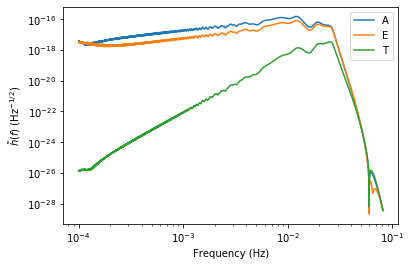

In [13]:
templates, start_inds, lengths = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=False, squeeze=False, length=1024)

print(templates, start_inds, lengths)

# plot the first binary
for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new[start_inds[0]:start_inds[0] + lengths[0]], np.abs(templates[0][i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")


The binaries can also be combined into one data stream with `fill=True` and `combine=True`. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

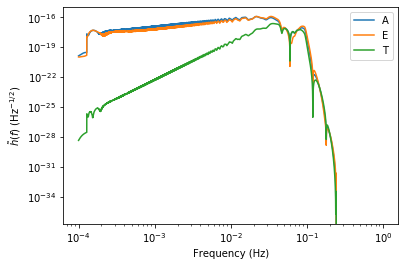

In [14]:
waves = wave_gen(m1, m2, a1, a2,
                  dist, phi_ref, f_ref, inc, lam, 
                  beta, psi, t_ref, freqs=freq_new,
                  modes=modes, direct=False, fill=True, combine=True, squeeze=False, length=1024)

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(waves[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

## Generating PhenomHM waveforms

 Now we will create PhenomHM waveforms in the source frame, but scaled for the distance. 

In [15]:
phenomhm = PhenomHMAmpPhase(use_gpu=False, run_phenomd=False)

In [16]:
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 1e6 
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 3e3  * PC_SI * 1e6 # 3e3 in Mpc 

phenomhm(
    m1,
    m2,
    a1,
    a2,
    dist,
    phi_ref,
    f_ref,
    1024
)

# get important quantities
freqs = phenomhm.freqs_shaped  # shape (num_bin_all, length)
amps = phenomhm.amp  # shape (num_bin_all, num_modes, length)
phase = phenomhm.phase  # shape (num_bin_all, num_modes, length)
tf = phenomhm.tf  # shape (num_bin_all, num_modes, length)

Plot Amplitudes

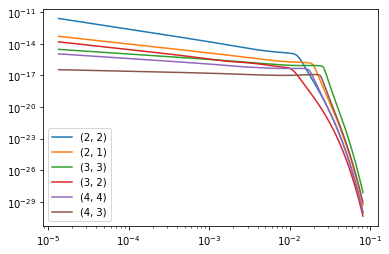

In [17]:
for i, mode in enumerate(modes):
    plt.loglog(freqs[0], amps[0, i], label=mode)
    
plt.legend()

## Fast FD Response

A large amount of the Fast FD Response codes were provided by Sylvain Marsat, so thank you to him! Detailed information on the response can be found in [arXiv:1806.10734](https://arxiv.org/abs/1806.10734) and [arXiv:2003.00357](https://arxiv.org/abs/2003.00357). The response works by applying an effective transfer function, $\mathcal{T}(f, t(f))$, to the waveform to get the TDI channels: 
$$\tilde{h}^{AET}(f) = \mathcal{T}(f, t(f))\tilde{h}^\text{SSB}(f),$$
where $t(f)$ is the time-frequency correspondence. This determines where the LISA constellation is in its orbit. This response function assumes the arms of the constellation are constant in time.

The response function operates directly on information coming from the base waveform generation in PhenomHM when you run `BBHWaveformFD`. To run the response separately you need to provide a phase and tf vector. The phase is adjusted inside the response code. If you do not want that to happen, you can add the keyword argument `adjust_phase=False`. If you are just running the response function to use it itself and not using to adjust phase, you can just put in zeros for the phase, it will not affect the computation. All parameters for the response are in the SSB frame. This function can take 1D arrays for the parameters as well. In this case, you need `freqs.shape=(num_bin_all, length)`, `phases.shape=tf.shape=(num_bin_all, num_modes, length)` with `num_bin_all` the total number of binaries, `num_modes` the number of harmonics, and `length` number of frequencies to evaluate per binary. 

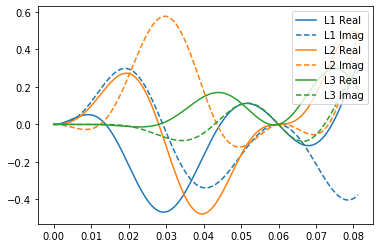

In [18]:
# use phase/tf information from last waveform run
freqs = phenomhm.freqs.copy()
phase = phenomhm.phase.copy()
tf = phenomhm.tf.copy()
modes = phenomhm.modes

phi_ref = 0.0
inc = np.pi/4
beta = np.pi/5
lam = np.pi/6
psi = np.pi/7

length = freqs.shape[-1]

response = LISATDIResponse()
response(freqs,
        inc,
        lam,
        beta,
        psi,
        phi_ref,
        length,
        phase=phase,
        tf=tf,
        modes=modes)

# plot parts of the response
for i in range(1, 4):
    
    # (2, 2) mode
    index = response.modes.index((2,2))
    # response.transferL1
    transfer = getattr(response, f"transferL{i}")
    plt.plot(freqs, transfer.real[0, index], label=f"L{i} Real", ls="solid", color=f"C{i-1}")
    plt.plot(freqs, transfer.imag[0, index], label=f"L{i} Imag", ls="dashed", color=f"C{i-1}")
plt.legend()

(10, 1024) (10, 6, 1024) (10, 6, 1024) (10, 6, 1024)


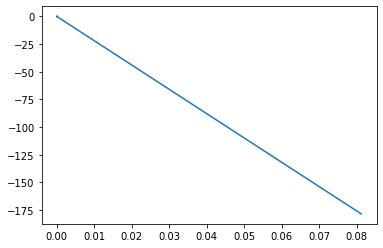

In [19]:
# use phase/tf information from last waveform run

num_bin_all = 10

freqs = np.tile(phenomhm.freqs.copy(), (num_bin_all, 1))
phase = np.tile(phenomhm.phase.copy(), (num_bin_all, 1, 1))
tf = np.tile(phenomhm.tf.copy(), (num_bin_all, 1, 1))

phi_ref = np.full(num_bin_all, 0.0)
inc = np.full(num_bin_all, np.pi/4)
beta = np.full(num_bin_all, np.pi/5)
lam = np.full(num_bin_all, np.pi/6)
psi = np.full(num_bin_all, np.pi/7)

length = freqs.shape[-1]

response(
    freqs,
    inc,
    lam,
    beta,
    psi,
    phi_ref,
    length,
    phase=phase,
    tf=tf,
    modes=None,  # defaults to phenomhm modes
    adjust_phase=True, # if you want to keep the phase array you input the same, set this to false. 
)  # You can get adjusted phases with response.phase
print(freqs.shape, phase.shape, tf.shape, response.transferL1.shape)

# get phase adjustment by response function
phase_diff = phase - phenomhm.phase

plt.plot(freqs[0], phase_diff[0, 0])

If building a waveform, you can also put a larger buffer object directly into the response code. This larger buffer object would be carrying amplitudes, phases, and tf from the source-frame waveform generator. 

In [20]:
num_bin_all = 10

length = 1024
num_modes = len(response.modes)
buffer_shape = (9, num_bin_all, num_modes, length)
out_buffer = np.zeros(buffer_shape).flatten()

f_ref = np.full(num_bin_all, 0.0)  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = np.full(num_bin_all, 0.0) # phase at f_ref
m1 = np.full(num_bin_all, 1e6) 
m2 = np.full(num_bin_all, 5e5)
a1 = np.full(num_bin_all, 0.2)
a2 = np.full(num_bin_all, 0.4)
dist = np.full(num_bin_all, 3e3)  * PC_SI * 1e6 # 3e3 in Mpc 

inc = np.full(num_bin_all, np.pi/4)
beta = np.full(num_bin_all, np.pi/5)
lam = np.full(num_bin_all, np.pi/6)
psi = np.full(num_bin_all, np.pi/7)

phenomhm(
    m1,
    m2,
    a1,
    a2,
    dist,
    phi_ref,
    f_ref,
    length,
    out_buffer=out_buffer
)

print(out_buffer.reshape(buffer_shape)[:, 0, 0, 0])

response(
    freqs,
    inc,
    lam,
    beta,
    psi,
    phi_ref,
    length,
    out_buffer=out_buffer,
    modes=None,  # defaults to phenomhm modes
) 

print(out_buffer.reshape(buffer_shape)[:, 0, 0, 0])
# these are all numbers at the first frequency for (2,2) mode for
# amp, phase, tf, transferL1re, transferL1im, transferL2re, transferL2im, transferL3re, transferL3im

[ 2.59987559e-12  7.38281574e+04 -1.44109019e+09  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[ 2.59987559e-12  7.38281579e+04 -1.44109019e+09 -1.19852960e-07
 -1.27213427e-07  2.47978234e-07 -6.83021491e-08  1.66473821e-18
  3.80562821e-19]
